# Version 2

## following koltens methods, resulting performance much more accurate

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


In [5]:
folder_path = "/Users/ellajones/Downloads/Optiver_additional data"


feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")


df_target = pd.read_parquet(target_path)
df_feature = pd.read_parquet(feature_path)

qqq_data = df_feature[df_feature['stock_id'] == 104919]

print(qqq_data.head())

          stock_id  time_id  seconds_in_bucket  bid_price1  ask_price1  \
15573802    104919       12                1.0      311.01      311.06   
15573803    104919       12                2.0      310.99      311.03   
15573804    104919       12                3.0      311.06      311.08   
15573805    104919       12                4.0      311.12      311.14   
15573806    104919       12                5.0      311.16      311.19   

          bid_price2  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  
15573802      311.00      311.08        996         97        900        800  
15573803      310.98      311.04        200        900        200        969  
15573804      311.04      311.09         96        269       1000        100  
15573805      311.11      311.15        800        200       1000        900  
15573806      311.15      311.20        232        200        200        800  


In [8]:
def compute_orderbook_features(qqq_data):
    qqq_data = qqq_data.copy()

    qqq_data['mid_price'] = (qqq_data['bid_price1'] + qqq_data['ask_price1']) / 2
    qqq_data['wap'] = (qqq_data['bid_price1'] * qqq_data['ask_size1'] + qqq_data['ask_price1'] * qqq_data['bid_size1']) / (
        qqq_data['bid_size1'] + qqq_data['ask_size1']
    )
    qqq_data['bid_ask_spread'] = qqq_data['ask_price1'] - qqq_data['bid_price1']
    qqq_data['spread_pct'] = qqq_data['bid_ask_spread'] / qqq_data['mid_price']
    qqq_data['spread_variation'] = qqq_data.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )
    qqq_data['imbalance'] = (qqq_data['bid_size1'] - qqq_data['ask_size1']) / (qqq_data['bid_size1'] + qqq_data['ask_size1'])
    qqq_data['depth_ratio'] = qqq_data['bid_size1'] / qqq_data['ask_size1'].replace(0, np.nan)

    qqq_data['wap_lag1'] = qqq_data.groupby(['stock_id', 'time_id'])['wap'].shift(1)
    qqq_data['wap_return'] = (qqq_data['wap'] - qqq_data['wap_lag1']) / qqq_data['wap_lag1']
    qqq_data['log_return'] = np.log(qqq_data['wap'] / qqq_data['wap_lag1'].replace(0, np.nan))

    qqq_data['wap_mean_10'] = qqq_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean())
    qqq_data['wap_std_10'] = qqq_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std())

    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'wap_lag1', 'wap_return', 'log_return',
        'wap_mean_10', 'wap_std_10',
        'spread_pct', 'spread_variation',
        'imbalance','depth_ratio'
    ]
    return qqq_data[keep_cols]

# Baseline Model

In [9]:

qqq_feat = compute_orderbook_features(qqq_data)

def realized_volatility(series):
    return np.sqrt(np.sum(np.square(np.diff(np.log(series)))))

rv_df = qqq_feat.groupby("time_id")["wap"].apply(realized_volatility).reset_index()
rv_df.columns = ["time_id", "rv"]

feature_agg_base = qqq_feat.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std'],
    'depth_ratio': ['mean', 'std'],
})
feature_agg_base.columns = ['_'.join(col) for col in feature_agg_base.columns]
feature_agg_base = feature_agg_base.reset_index()

data = pd.merge(feature_agg_base, rv_df, on="time_id", how="inner")

In [10]:
data = data.sort_values(by="time_id")
unique_ids = sorted(data["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df = data[data["time_id"].isin(train_ids)]
test_df = data[data["time_id"].isin(test_ids)]
X_train = train_df.drop(columns=["time_id", "rv"])
y_train = train_df["rv"]
X_test = test_df.drop(columns=["time_id", "rv"])
y_test = test_df["rv"]


 Chronological 80/20 Split Evaluation:
MSE: 2.3376191753992468e-07
R²:  0.6974
QLIKE: -5.398599


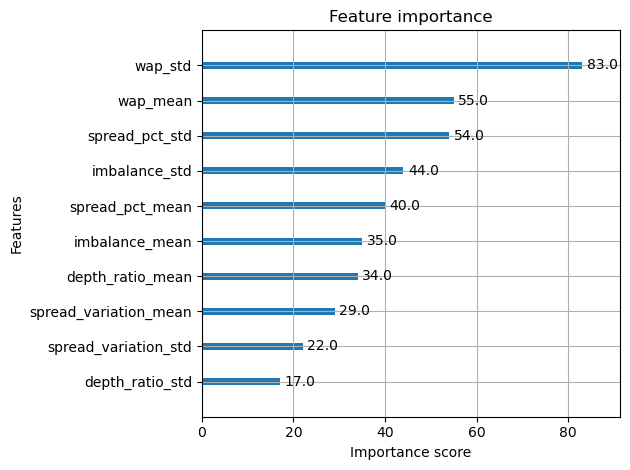

In [11]:
# XGBoost
model1 = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model1.fit(X_train, y_train)

def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None) 
    return np.mean(np.log(y_pred) + (y_true / y_pred))


y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print(" Chronological 80/20 Split Evaluation:")
print(f"MSE: {mse}")
print(f"R²:  {r2:.4f}")
print(f"QLIKE: {qlike_score:.6f}")

plot_importance(model1)
plt.tight_layout()
plt.show()

# Adding more features

In [13]:
feature_agg = qqq_feat.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std', 'max', 'min'],
    'depth_ratio': ['mean', 'std'],
    'wap_return': ['mean',  'max', 'min', 'skew'],
    'log_return': ['mean',  'max', 'min', 'skew'],
    'wap_mean_10': ['mean', 'std'],
    'wap_std_10': ['mean', 'std']
})

feature_agg.columns = ['_'.join(col) for col in feature_agg.columns]
feature_agg = feature_agg.reset_index()

data_2 = pd.merge(feature_agg, rv_df, on="time_id", how="inner")

In [14]:
data_2 = data_2.sort_values(by="time_id")
unique_ids = sorted(data_2["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df = data_2[data_2["time_id"].isin(train_ids)]
test_df = data_2[data_2["time_id"].isin(test_ids)]
X_train = train_df.drop(columns=["time_id", "rv"])
y_train = train_df["rv"]
X_test = test_df.drop(columns=["time_id", "rv"])
y_test = test_df["rv"]

 Chronological 80/20 Split Evaluation:
MSE: 2.4459806185064863e-08
R²:  0.9683
QLIKE: -5.426641


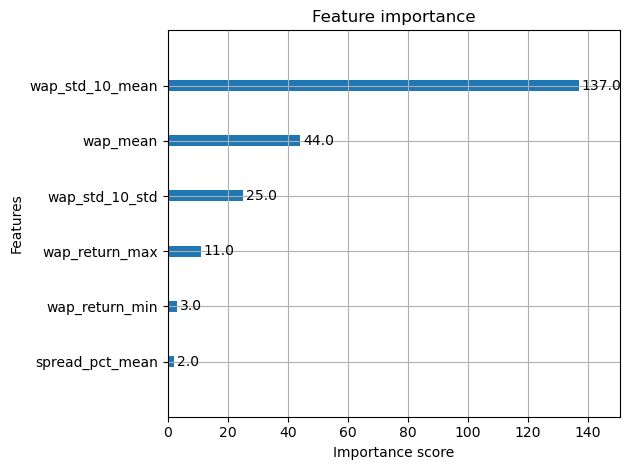

In [15]:

# XGBoost
model2 = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model2.fit(X_train, y_train)

def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None)  
    return np.mean(np.log(y_pred) + (y_true / y_pred))


y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print(" Chronological 80/20 Split Evaluation:")
print(f"MSE: {mse}")
print(f"R²:  {r2:.4f}")
print(f"QLIKE: {qlike_score:.6f}")

plot_importance(model2)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [24]:
model_better = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model_better.fit(X_train, y_train)

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=model_better,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
Best Parameters: {'max_depth': 4, 'min_child_weight': 3}
Best Score: -1.1279437450481833e-07


In [25]:
# Use the current best max_depth and min_child_weight to validate
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=3,
    random_state=42
)

# Define the range for gamma
param_grid = {
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print("Best gamma:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best gamma: {'gamma': 0}
Best score: -1.1279437450481833e-07


In [26]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=3,
    gamma=0,
    random_state=42
)

# the range for subsample and colsample_bytree
param_grid = {
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best parameters: {'colsample_bytree': 1.0, 'subsample': 0.5}
Best score: -9.019020277186861e-08


In [27]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=3,
    gamma=0,
    subsample=0.5,
    colsample_bytree=1,
    random_state=42
)

param_grid = {
    'reg_alpha': [0, 0.001, 0.01, 0.05, 0.1],   # L1 regularization
    'reg_lambda': [0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.5]  # L2 regularization
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best regularization parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best regularization parameters: {'reg_alpha': 0, 'reg_lambda': 0.7}
Best score: -8.70753350727944e-08


In [31]:

final_model = XGBRegressor(
    learning_rate=0.05,
    n_estimators=300,  # add more tree num to make up for learning rate
    max_depth=4,
    min_child_weight=3,
    gamma=0,
    subsample=0.5,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0.7,
    random_state=42
)

# final model
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print("the final output：")
print(f"MSE: {mse:.8f}")
print(f"R² : {r2:.4f}")
print(f"QLIKE: {qlike_score:.6f}")

the final output：
MSE: 0.00000003
R² : 0.9656
QLIKE: -5.425467


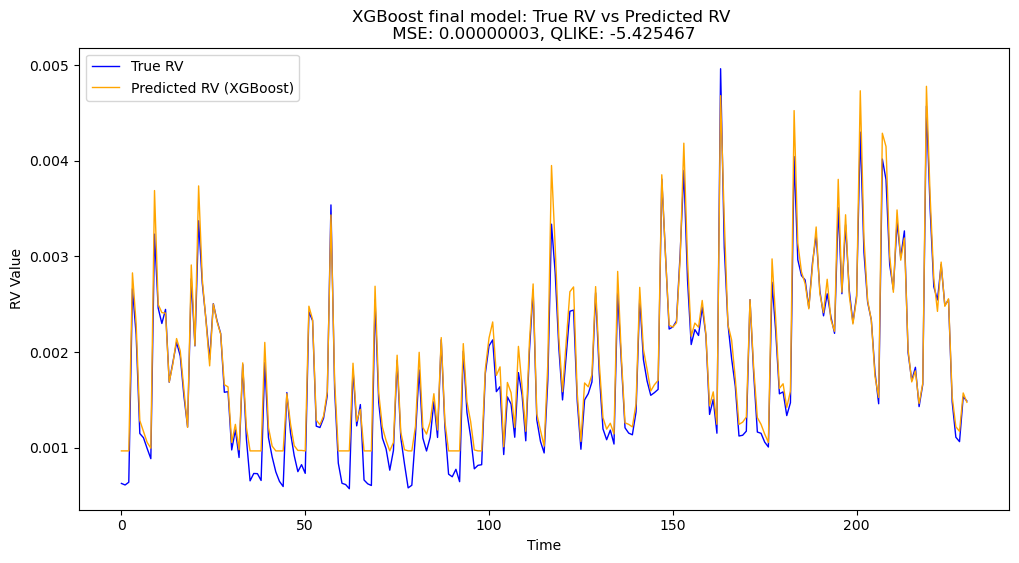

In [34]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True RV', color='blue', linewidth=1)
plt.plot(y_pred, label='Predicted RV (XGBoost)', color='orange', linewidth=1)
plt.title(f'XGBoost final model: True RV vs Predicted RV \n MSE: {mse:.8f}, QLIKE: {qlike_score:.6f} ')
plt.xlabel('Time')
plt.ylabel('RV Value')
plt.legend()
plt.show()